In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from itertools import combinations
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.inspection import PartialDependenceDisplay

# 1. Define KRLS

In [228]:
def gaussian_kernel(X1, X2, sigma):
    """
    Compute the Gaussian (RBF) kernel matrix using scikit-learn's rbf_kernel.
    :param X1: Data matrix A (n_samples_A, n_features), can be a DataFrame or ndarray
    :param X2: Data matrix B (n_samples_B, n_features), can be a DataFrame or ndarray
    :param sigma: Bandwidth of the Gaussian kernel
    :return: Gaussian kernel matrix
    """
    if isinstance(X1, (pd.DataFrame, pd.Series)):
        X1 = X1.values
    if isinstance(X2, (pd.DataFrame, pd.Series)):
        X2 = X2.values

    gamma = 1.0 / (2 * sigma**2)
    return rbf_kernel(X1, X2, gamma=gamma)

In [229]:
"""
Construct KRLS algorithm
hyperparameter: sigma, alpha
"""

class KRLS(BaseEstimator, RegressorMixin):
    def __init__(self, sigma=1.0, alpha=1.0):
        """
        Initialize KRLS
        :param sigma: width of kernel
        :param alpha: regularized parameter
        """
        self.sigma = sigma
        self.alpha = alpha
    
    def fit(self, X, y):
        """
        Train KRLS model
        :param X: training data (n_samples, n_features)
        :param y: observed value (n_samples,)
        """
        self.X_train = X
        K = gaussian_kernel(X, X, self.sigma)
        self.alpha_ = np.linalg.inv(K + self.alpha * np.eye(K.shape[0])).dot(y)
        return self
    
    def predict(self, X):
        """
        Use fitted KRLS model to predict
        :param X: testing data (n_samples, n_features)
        :return: predicted value
        """
        K = gaussian_kernel(X, self.X_train, self.sigma)
        return K.dot(self.alpha_)
    
    def get_params(self, deep=True):
        """
        Get parameters of KRLS model
        """
        return {"sigma": self.sigma, "alpha": self.alpha}
    
    def set_params(self, **parameters):
        """
        Set parameters of KRLS model
        """
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# 2. Use KRLS to make basic analysis

## a. Use simple data

In [230]:
if __name__ == "__main__":
    # Define parameter
    beta_0 = 1
    beta_1, beta_2, beta_3, beta_4, beta_5 = 2, 3, 4, 5, 6
    beta_12, beta_45 = 1.5, -2

    # Generate data
    np.random.seed(42) # Make sure data can be repeatable

    # X1, ..., X4 follows normal distribution
    X1 = np.random.normal(1, 1, 1000)
    X2 = np.random.normal(1, 1, 1000)
    X3 = np.random.normal(1, 1, 1000)
    X4 = np.random.normal(1, 1, 1000)

    # X5 follows uniform distribution
    X5 = np.random.uniform(0, 1, 1000)

    # Calculate Y with intersection between X1 and X2, X3 and X4
    Y_simple = (beta_0 + beta_1*X1 + beta_2*X2 + beta_3*X3 + beta_4*X4 + beta_5*X5 +
        beta_12*(X1*X2) + beta_45*(X4*X5) # intersection part
        + np.random.normal(0, 0.1, 1000)) # add some noise

    # Create DataFrame
    Synthetic_data1 = pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'X3': X3,
        'X4': X4,
        'X5': X5,
        'Y': Y_simple
    })
    
    X_data_1 = Synthetic_data1.drop('Y', axis=1)
    Y_data_1 = Synthetic_data1['Y']
    
    # Split train and test dataset
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data_1, Y_data_1, test_size=0.2, random_state=42)

In [231]:
# Perform linear regression
model_linear1 = LinearRegression()
model_linear1.fit(X_data_1, Y_data_1)

# Predict Y values
Y_pred_linear1 = model_linear1.predict(X_data_1)

# Print coefficients
print("Coefficients:", model_linear1.coef_)
print("Intercept:", model_linear1.intercept_)

# Evaluate the model
mse_linear1 = mean_squared_error(Y_data_1, Y_pred_linear1)
r2_linear1 = r2_score(Y_data_1, Y_pred_linear1)
print("Mean Squared Error:", mse_linear1)
print("R-squared:", r2_linear1)

Coefficients: [3.66866756 4.56775098 4.04398867 3.94388468 4.17061951]
Intercept: 0.11024329268729716
Mean Squared Error: 2.4109439189794655
R-squared: 0.964158095335306


## b. Find hyperparameter

In [232]:
"""
Use grid search to find the optimized hyperparameter
"""

# Define parameter grid
param_grid1 = {
    'sigma': np.logspace(-2, 2, 5),  # Explore different sigma values, e.g., from 0.01 to 100
    'alpha': np.logspace(-2, 2, 5)   # Explore different alpha values, e.g., from 0.01 to 100
}

# Instantiate grid search
grid_search1 = GridSearchCV(KRLS(), param_grid1, cv=5, scoring='r2', verbose=1)

# Run grid search
grid_search1.fit(X_train1, y_train1)

# Output best parameters and best score
print("Best parameters:", grid_search1.best_params_)
print("Best cross-validation score (r2):", grid_search1.best_score_)

# Use best parameters to re-train model
best_sigma1 = grid_search1.best_params_['sigma']
best_alpha1 = grid_search1.best_params_['alpha']

krls_optimized1 = KRLS(sigma=best_sigma1, alpha=best_alpha1)
krls_optimized1.fit(X_train1, y_train1)

# Make predictions and evaluate the optimized model
y_pred_optimized1 = krls_optimized1.predict(X_test1)
mse_optimized1 = mean_squared_error(y_test1, y_pred_optimized1)
r2_optimized1 = r2_score(y_test1, y_pred_optimized1)

print("Optimized Mean Squared Error:", mse_optimized1)
print("Optimized R-squared:", r2_optimized1)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.01, 'sigma': 10.0}
Best cross-validation score (r2): 0.9963582033355832
Optimized Mean Squared Error: 0.24132247546831995
Optimized R-squared: 0.9964148933164426


## c. Use Partial differential

In [233]:
def approximate_derivative(model, X, feature_index, epsilon=1e-4):
    """
    Approximate the partial derivative of a given feature using the central difference method.
    
    Parameters:
    - model: The trained model, which has a .predict() method.
    - X: Array of input data points (n_samples, n_features).
    - feature_index: The index of the feature for which to compute the partial derivative.
    - epsilon: A small perturbation used to compute the numerical derivative.
    
    Returns:
    - The approximate value of the derivative.
    """
    # Create two datapoints
    X_plus = X.copy()
    X_minus = X.copy()
    
    X_plus[:, feature_index] += epsilon
    X_minus[:, feature_index] -= epsilon
    
    # Predict datapoints
    pred_plus = model.predict(X_plus)
    pred_minus = model.predict(X_minus)
    
    # Calculate derivarives
    derivative = (pred_plus - pred_minus) / (2 * epsilon)
    return derivative

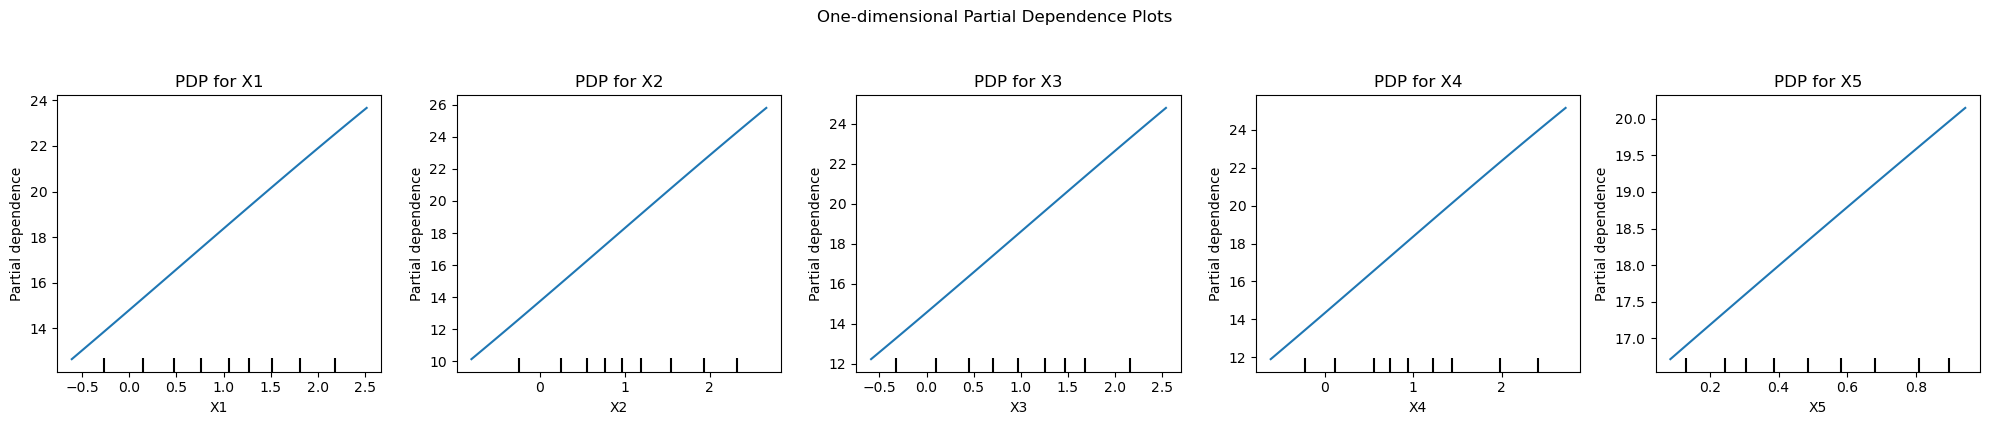

In [258]:
# Create figure
fig1, axes1 = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

# Draw PDP for each feature
features_to_plot1 = ['X1', 'X2', 'X3', 'X4', 'X5']
for i, feature in enumerate(features_to_plot1):
    display = PartialDependenceDisplay.from_estimator(
        krls_optimized1,
        X_test1,
        features=[feature],
        kind='average',
        ax=axes1[i]
    )
    axes1[i].set_title(f'PDP for {feature}')
    axes1[i].set_xlabel(feature)
    axes1[i].set_ylabel('Partial Dependence')

# set title
plt.suptitle('One-dimensional Partial Dependence Plots', y=1.05)
plt.tight_layout()

# show the figure
plt.show()

Comparison of mean partial derivatives and coefficients of features:
    Average_Derivative  Coefficient  Difference
X1            3.511334     3.668668   -0.157333
X2            4.511068     4.567751   -0.056683
X3            4.002900     4.043989   -0.041088
X4            3.984972     3.943885    0.041087
X5            3.989943     4.170620   -0.180677


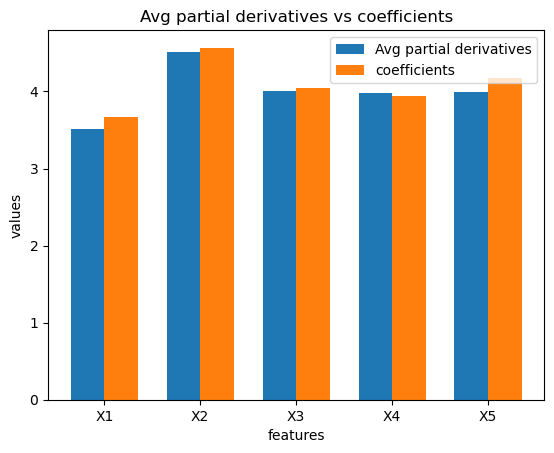

In [276]:
"""
Calculate average partial derivatives
"""

feature_names1 = X_train1.columns

# Initialize empty dictionary
derivatives_with_labels1 = {}
average_derivatives1 = {}

for feature_index, feature_name in enumerate(feature_names1):
    # Calculate partial derivatives
    derivative = approximate_derivative(krls_optimized1, X_test1.to_numpy(), feature_index)
    
    # Calculate average value
    average_derivative = np.mean(derivative)
    
    # Store partial derivatives
    average_derivatives1[feature_name] = average_derivative
    derivatives_with_labels1[feature_name] = derivative
    
# Collect all average partial derivatives
average_derivatives_str1 = ", ".join([f"{feature_name}: {average_derivative:.4f}" for feature_name, average_derivative in average_derivatives1.items()])

# Use coefficients of linear regression
linear_coefficients1 = model_linear1.coef_

# Trans to Dataframe
df_derivatives1 = pd.DataFrame.from_dict(average_derivatives1, orient='index', columns=['Average_Derivative'])
df_derivatives1['Coefficient'] = linear_coefficients1
df_derivatives1['Difference'] = df_derivatives1['Average_Derivative'] - df_derivatives1['Coefficient']

# Print result
print("Comparison of mean partial derivatives and coefficients of features:")
print(df_derivatives1)

# Draw figure
features1 = df_derivatives1.index
average_derivative_values1 = df_derivatives1['Average_Derivative']
linear_coefficients_values1 = df_derivatives1['Coefficient']

x1 = np.arange(len(features1))
width = 0.35

fig2, ax2 = plt.subplots()
rects1 = ax2.bar(x1 - width/2, average_derivative_values1, width, label='Avg partial derivatives')
rects2 = ax2.bar(x1 + width/2, linear_coefficients_values1, width, label='coefficients')

ax2.set_xlabel('features')
ax2.set_ylabel('values')
ax2.set_title('Avg partial derivatives vs coefficients')
ax2.set_xticks(x1)
ax2.set_xticklabels(features1)
ax2.legend()

plt.show()

Comparison of mean partial derivatives and coefficients of features:
    Average_Derivative  Coefficient  Difference
X1            3.511334            2    1.511334
X2            4.511068            3    1.511068
X3            4.002900            4    0.002900
X4            3.984972            5   -1.015028
X5            3.989943            6   -2.010057


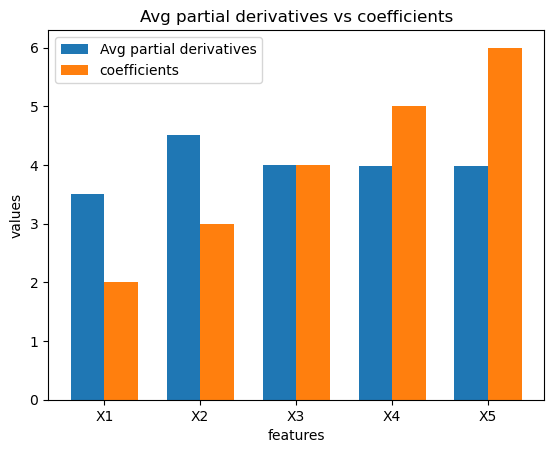

In [277]:
"""
Calculate partial detivatives
"""

feature_names11 = X_train1.columns

# Initialize empty dictionary
derivatives_with_labels11 = {}
average_derivatives11 = {}

for feature_index, feature_name in enumerate(feature_names1):
    # Calculate partial derivatives
    derivative = approximate_derivative(krls_optimized1, X_test1.to_numpy(), feature_index)
    
    # Calculate average value
    average_derivative = np.mean(derivative)
    
    # Store partial derivatives
    average_derivatives11[feature_name] = average_derivative
    derivatives_with_labels11[feature_name] = derivative
    
# Collect all average partial derivatives
average_derivatives_str11 = ", ".join([f"{feature_name}: {average_derivative:.4f}" for feature_name, average_derivative in average_derivatives1.items()])

# Coefficient is defined
beta_coefficients = {
    'X1': 2,
    'X2': 3,
    'X3': 4,
    'X4': 5,
    'X5': 6
}

# Trans to Dataframe
df_derivatives11 = pd.DataFrame.from_dict(average_derivatives11, orient='index', columns=['Average_Derivative'])
df_derivatives11['Coefficient'] = [beta_coefficients[feature_name] for feature_name in df_derivatives11.index]
df_derivatives11['Difference'] = df_derivatives11['Average_Derivative'] - df_derivatives11['Coefficient']

# Print results
print("Comparison of average partial derivatives and coefficients of features:")
print(df_derivatives11)

# draw figure
features11 = df_derivatives11.index
average_derivative_values11 = df_derivatives11['Average_Derivative']
beta_values11 = df_derivatives11['Coefficient']

x11 = np.arange(len(features11))
width = 0.35

fig22, ax22 = plt.subplots()
rects11 = ax22.bar(x11 - width/2, average_derivative_values11, width, label='Avg partial derivatives')
rects22 = ax22.bar(x11 + width/2, beta_values11, width, label='coefficients')

ax22.set_xlabel('features')
ax22.set_ylabel('values')
ax22.set_title('Avg partial derivatives vs coefficients')
ax22.set_xticks(x11)
ax22.set_xticklabels(features11)
ax22.legend()

plt.show()

## d. Find interaction

In [236]:
def add_interaction_terms(X, interaction_pairs):
    """
    Add interaction term to variable list
    """
    X_interacted = X.copy()
    for pair in interaction_pairs:
        new_column_name = f"interaction_{'_'.join(pair)}"
        X_interacted[new_column_name] = X_interacted[pair[0]] * X_interacted[pair[1]]
    return X_interacted

In [237]:
# Prepare data
X_train1_copy1 = X_train1.copy()
y_train1_copy1 = y_train1.copy()

# list to collect scores
interaction_scores1 = []

# Find all possible interactions
selected_columns1 = ['X1', 'X2', 'X4', 'X5']
all_pairs1 = list(combinations(selected_columns1, 2))

for pair in all_pairs1:
    # Add interaction term
    X_train_interacted1 = add_interaction_terms(X_train1_copy1, [pair])
    
    # Use cross validation to evaluate
    score1 = np.mean(cross_val_score(krls_optimized1, X_train_interacted1, y_train1_copy1, cv=5, scoring='r2'))
    
    # store the interaction term and corresponding score
    interaction_scores1.append((pair, score1))

# Order by scores
sorted_interactions1 = sorted(interaction_scores1, key=lambda x: x[1], reverse=True)

# Choose top N interaction terms
N = 5  
best_interactions1 = sorted_interactions1[:N]

# Print top N interaction terms
print(f"Top {N} interactions:")
for interaction, score in best_interactions1:
    print(f"Interaction: {interaction}, Mean Score: {score}")

Top 5 interactions:
Interaction: ('X4', 'X5'), Mean Score: 0.9985657292051313
Interaction: ('X1', 'X5'), Mean Score: 0.9969246691221082
Interaction: ('X1', 'X2'), Mean Score: 0.9969245836995995
Interaction: ('X2', 'X5'), Mean Score: 0.9967617460729157
Interaction: ('X1', 'X4'), Mean Score: 0.9962105933392458


In [239]:
# prepare data
X_train1_copy2 = X_train1.copy()
y_train1_copy2 = y_train1.copy()

threshold = 0.001
previous_best_mse1 = np.inf
N1 = 5
original_features1 = X_train1_copy2.columns.tolist()
selected_interactions1 = []

# Iterative process
for iteration in range(N1):
    best_score1 = -np.inf
    best_interaction1 = None
    best_mse1 = np.inf
    best_r2_1 = -np.inf
    
    # interactions between original features
    all_pairs11 = list(combinations(original_features1, 2))
    
    for pair in all_pairs11:
        # Create new data
        X_train_interacted = X_train1_copy2.copy()
        interaction_name1 = "_".join(pair) + "_interaction"
        X_train_interacted[interaction_name1] = X_train_interacted[pair[0]] * X_train_interacted[pair[1]]
        
        # Use cross-validation to evaluate
        scores1 = cross_validate(krls_optimized1, X_train_interacted, y_train1_copy2, cv=5, scoring=('neg_mean_squared_error', 'r2'))
        current_mse1 = -np.mean(scores1['test_neg_mean_squared_error'])
        current_r2_1 = np.mean(scores1['test_r2'])
        
        if current_mse1 < best_mse1:
            best_mse1 = current_mse1
            best_interaction1 = pair
            best_interaction_name1 = interaction_name1
            best_r2_1 = current_r2_1

    if previous_best_mse1 - best_mse1 < threshold:
        print("MSE improvement is below the threshold. Stopping iteration.")
        break
    else:
        previous_best_mse1 = best_mse1
        if best_interaction1:
            selected_interactions1.append(best_interaction1)
            print(f"Iteration {iteration+1}: Selected interaction: {best_interaction1}, Mean MSE: {best_mse1}, Mean R2: {best_r2_1}")
            # renew the dataset
            X_train1_copy2[best_interaction_name1] = X_train1_copy2[best_interaction1[0]] * X_train1_copy2[best_interaction1[1]]
        else:
            print("No further improvement.")
            break

Iteration 1: Selected interaction: ('X4', 'X5'), Mean MSE: 0.09722431865832078, Mean R2: 0.9985657292051313
Iteration 2: Selected interaction: ('X1', 'X2'), Mean MSE: 0.0504981548032461, Mean R2: 0.9992505000054374
MSE improvement is below the threshold. Stopping iteration.


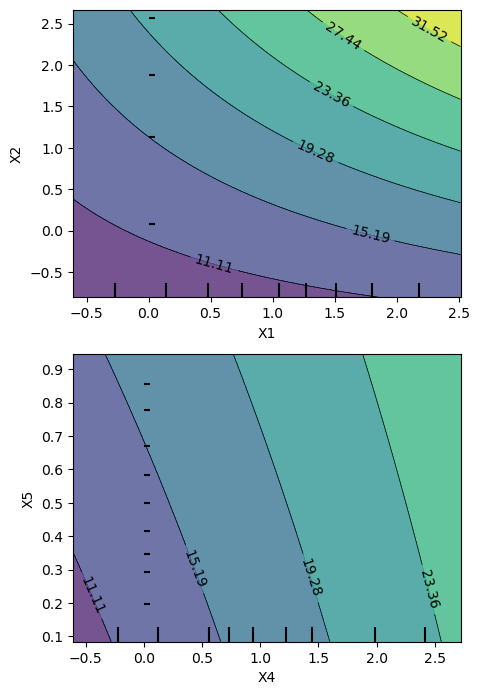

In [294]:
# Draw two-dimensional PDP
fig3, ax3 = plt.subplots(nrows=2, figsize=(5, 8))  # nrows=2 for vertical arrangement
display2 = PartialDependenceDisplay.from_estimator(
    krls_optimized1, 
    X_test1, 
    [('X1', 'X2'), ('X4', 'X5')], 
    ax=ax3
)
# plt.suptitle('Partial Dependence Plots for KRLS Model')
plt.subplots_adjust(top=0.9, hspace=0.2)  # Adjust hspace for vertical spacing
plt.show()

# 3. Use complex data include three terms interaction to analyze

## a. Construct data

In [241]:
if __name__ == "__main__":
    np.random.seed(42)  # Make sure data can be repeatable

    # Define parameter
    beta_0_2 = 1
    betas_2 = np.random.uniform(1, 5, 10)  # random generation

    # Generate features
    X_2 = np.random.normal(1, 1, (1000, 10))

    # Feature name
    feature_names2 = [f'X{i+1}' for i in range(10)]

    # Generate interaction part
    beta_16 = 2
    beta_89 = -1
    beta_234 = 2.5

    # Calculate Y
    Y_complex = beta_0_2 + np.dot(X_2, betas_2) + beta_16 * X_2[:,0] * X_2[:,5] + beta_89 * np.sin(X_2[:,7]) * X_2[:,8] + beta_234 * X_2[:, 1] * X_2[:, 2] * X_2[:, 3] + np.random.normal(0, 0.1, 1000)

    # Create DataFrame
    Synthetic_data2 = pd.DataFrame(X_2, columns=feature_names2)
    Synthetic_data2['Y'] = Y_complex
    
    X_data_2 = Synthetic_data2.drop('Y', axis=1)
    Y_data_2 = Synthetic_data2['Y']
    
    # Split train and test dataset
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data_2, Y_data_2, test_size=0.2, random_state=42)

In [270]:
# Perform linear regression
model_linear2 = LinearRegression()
model_linear2.fit(X_data_2, Y_data_2)

# Predict Y values
Y_pred_linear2 = model_linear2.predict(X_data_2)

# Print coefficients
print("Coefficients:", model_linear2.coef_)
print("Intercept:", model_linear2.intercept_)

# Evaluate the model
mse_linear2 = mean_squared_error(Y_data_2, Y_pred_linear2)
r2_linear2 = r2_score(Y_data_2, Y_pred_linear2)
print("Mean Squared Error:", mse_linear2)
print("R-squared:", r2_linear2)

Coefficients: [4.44079006 7.5506782  6.79211312 5.98087704 1.54755732 3.79249312
 1.14377368 3.99436473 3.04077948 4.09690891]
Intercept: -6.65433784800517
Mean Squared Error: 25.247526054499787
R-squared: 0.8912225408518993


## b. find hyperparameter

In [243]:
"""
Optimize the hyperparameter of KRLS
"""

# define grid
param_grid2 = {
    'sigma': np.logspace(-2, 2, 5),
    'alpha': np.logspace(-2, 2, 5)
}

# optimize KRLS model
grid_search2 = GridSearchCV(KRLS(), param_grid2, cv=5, scoring='r2', verbose=1)
grid_search2.fit(X_train2, y_train2)

# Output
print("Best parameters:", grid_search2.best_params_)
print("Best cross-validation score (r2):", grid_search2.best_score_)

# Use optimized hyperparameter to retrain the model
best_sigma2 = grid_search2.best_params_['sigma']
best_alpha2 = grid_search2.best_params_['alpha']

krls_optimized2 = KRLS(sigma=best_sigma2, alpha=best_alpha2)
krls_optimized2.fit(X_train2, y_train2)

# Use optimized KRLS model to predict
y_pred_optimized2 = krls_optimized2.predict(X_test2)
mse_optimized2 = mean_squared_error(y_test2, y_pred_optimized2)
print("Optimized Mean Squared Error:", mse_optimized2)

# Calculate out-of-sample R^2
r2_optimized2 = r2_score(y_test2, y_pred_optimized2)
print("Optimized Out-of-Sample R^2:", r2_optimized2)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.01, 'sigma': 10.0}
Best cross-validation score (r2): 0.9736066968810375
Optimized Mean Squared Error: 6.3326846452324626
Optimized Out-of-Sample R^2: 0.9736340069919885


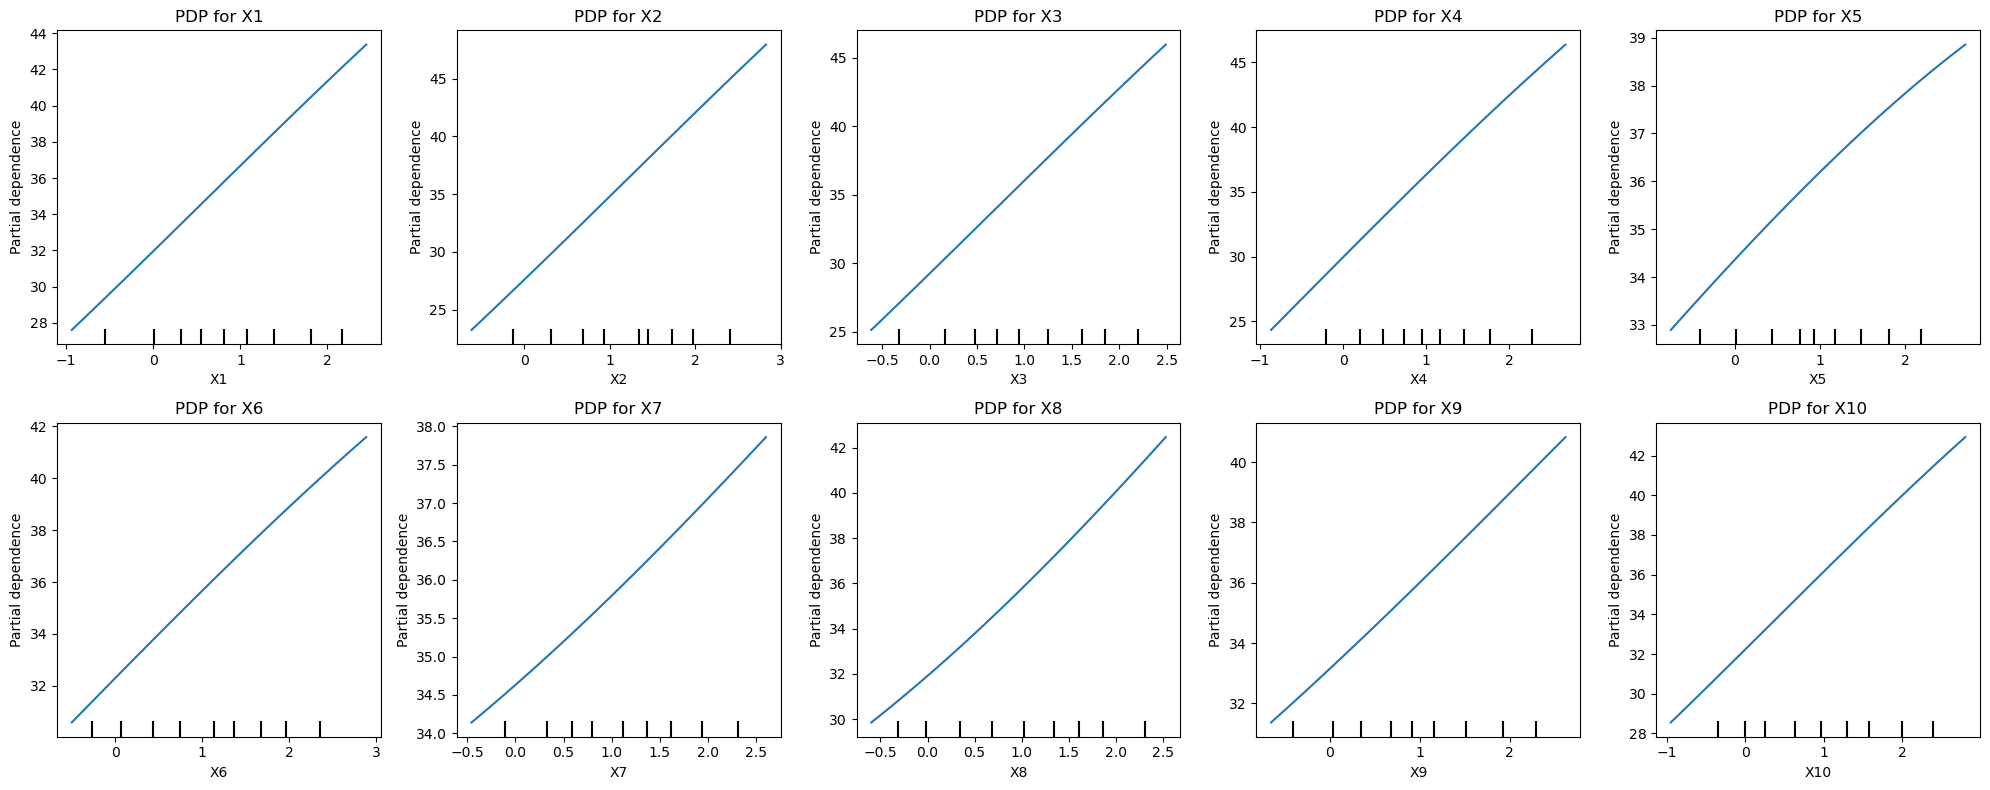

In [265]:
# Create figure
fig4, axes4 = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Draw PDP
features_to_plot2 = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
for i, feature in enumerate(features_to_plot2):
    row = i // 5
    col = i % 5
    
    display = PartialDependenceDisplay.from_estimator(
        krls_optimized2,
        X_test2,
        features=[feature],
        kind='average',
        ax=axes4[row, col]
    )
    axes4[row, col].set_title(f'PDP for {feature}')
    axes4[row, col].set_xlabel(feature)
    axes4[row, col].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

Comparison of average partial derivatives and coefficients of features:
     Average_Derivative  Coefficient  Difference
X1             4.676515     2.498160    2.178355
X2             7.170309     4.802857    2.367452
X3             6.691232     3.927976    2.763256
X4             6.214466     3.394634    2.819832
X5             1.735028     1.624075    0.110954
X6             3.264033     1.623978    1.640055
X7             1.211636     1.232334   -0.020698
X8             4.036842     4.464705   -0.427863
X9             2.888541     3.404460   -0.515919
X10            3.824257     3.832290   -0.008034


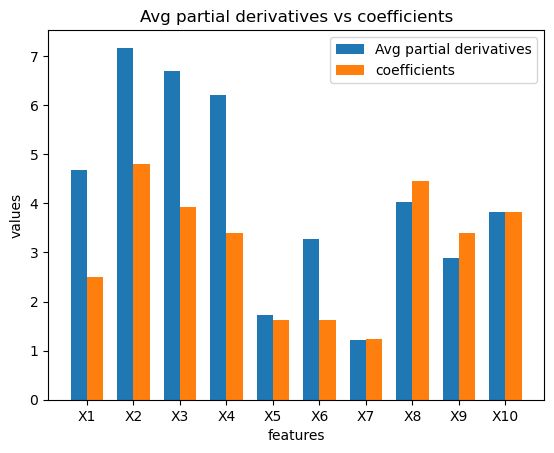

In [279]:
"""
Calculate partial detivatives
"""

feature_names2 = X_train2.columns

# Initialize dictionaries
derivatives_with_labels2 = {}
average_derivatives2 = {}

for feature_index, feature_name in enumerate(feature_names2):
    # Calculate partial derivatives
    derivative2 = approximate_derivative(krls_optimized2, X_test2.to_numpy(), feature_index)
    
    # Calculate average partial derivatives
    average_derivative2 = np.mean(derivative2)
    average_derivatives2[feature_name] = average_derivative2
    derivatives_with_labels2[feature_name] = derivative2
    
# Collect all average derivatives
average_derivatives_str2 = ", ".join([f"{feature_name}: {average_derivative:.4f}" for feature_name, average_derivative in average_derivatives2.items()])

beta_coefficients2 = {
    'X1': betas_2[0],
    'X2': betas_2[1],
    'X3': betas_2[2],
    'X4': betas_2[3],
    'X5': betas_2[4],
    'X6': betas_2[5],
    'X7': betas_2[6],
    'X8': betas_2[7],
    'X9': betas_2[8],
    'X10': betas_2[9],
}

# Trans to dataframe
df_derivatives2 = pd.DataFrame.from_dict(average_derivatives2, orient='index', columns=['Average_Derivative'])
df_derivatives2['Coefficient'] = [beta_coefficients2[feature_name] for feature_name in df_derivatives2.index]
df_derivatives2['Difference'] = df_derivatives2['Average_Derivative'] - df_derivatives2['Coefficient']

# print results
print("Comparison of average partial derivatives and coefficients of features:")
print(df_derivatives2)

# Draw figure
features2 = df_derivatives2.index
average_derivative_values2 = df_derivatives2['Average_Derivative']
beta_values2 = df_derivatives2['Coefficient']

x2 = np.arange(len(features2))
width = 0.35

fig5, ax5 = plt.subplots()
rects3 = ax5.bar(x2 - width/2, average_derivative_values2, width, label='Avg partial derivatives')
rects4 = ax5.bar(x2 + width/2, beta_values2, width, label='coefficients')

ax5.set_xlabel('features')
ax5.set_ylabel('values')
ax5.set_title('Avg partial derivatives vs coefficients')
ax5.set_xticks(x2)
ax5.set_xticklabels(features2)
ax5.legend()

plt.show()

特征的平均偏导数与系数的比较：
     Average_Derivative  Coefficient  Difference
X1             4.676515     4.440790    0.235725
X2             7.170309     7.550678   -0.380369
X3             6.691232     6.792113   -0.100881
X4             6.214466     5.980877    0.233589
X5             1.735028     1.547557    0.187471
X6             3.264033     3.792493   -0.528460
X7             1.211636     1.143774    0.067863
X8             4.036842     3.994365    0.042477
X9             2.888541     3.040779   -0.152238
X10            3.824257     4.096909   -0.272652


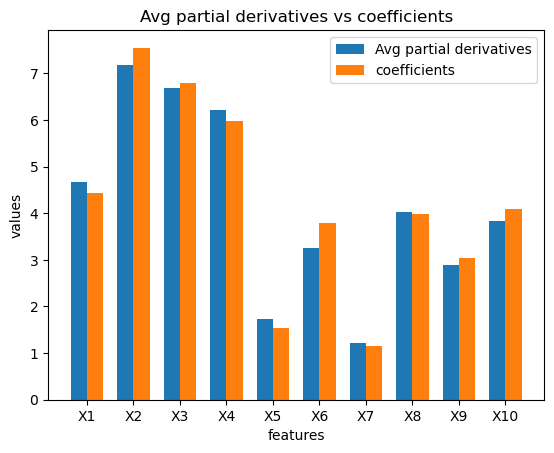

In [273]:
"""
Calculate partial derivative
"""

feature_names22 = X_train2.columns

# Initialize dictionary
derivatives_with_labels22 = {}
average_derivatives22 = {}

for feature_index, feature_name in enumerate(feature_names22):
    # Calculate partial derivative
    derivative = approximate_derivative(krls_optimized2, X_test2.to_numpy(), feature_index)
    
    # Calculate average partial derivative
    average_derivative = np.mean(derivative)
    average_derivatives22[feature_name] = average_derivative
    derivatives_with_labels22[feature_name] = derivative
    
# Collect average partial derivative
average_derivatives_str22 = ", ".join([f"{feature_name}: {average_derivative:.4f}" for feature_name, average_derivative in average_derivatives1.items()])

# Use coefficients in linear regression
linear_coefficients2 = model_linear2.coef_

# Trans to dataframe
df_derivatives22 = pd.DataFrame.from_dict(average_derivatives22, orient='index', columns=['Average_Derivative'])
df_derivatives22['Coefficient'] = linear_coefficients2
df_derivatives22['Difference'] = df_derivatives22['Average_Derivative'] - df_derivatives22['Coefficient']

# print result
print("Comparison of average partial derivatives and coefficients of features:")
print(df_derivatives22)

# Draw figure
features22 = df_derivatives22.index
average_derivative_values22 = df_derivatives22['Average_Derivative']
linear_coefficients_values22 = df_derivatives22['Coefficient']

x22 = np.arange(len(features22))
width = 0.35

fig55, ax55 = plt.subplots()
rects33 = ax55.bar(x22 - width/2, average_derivative_values22, width, label='Avg partial derivatives')
rects44 = ax55.bar(x22 + width/2, linear_coefficients_values22, width, label='coefficients')

ax55.set_xlabel('features')
ax55.set_ylabel('values')
ax55.set_title('Avg partial derivatives vs coefficients')
ax55.set_xticks(x22)
ax55.set_xticklabels(features22)
ax55.legend()

plt.show()

## c. Find interaction

In [246]:
# prepare data
X_train2_copy1 = X_train2.copy()
y_train2_copy1 = y_train2.copy()
interaction_scores2 = []

# Find all interaction terms
selected_columns2 = ['X1', 'X2', 'X3', 'X4', 'X6', 'X8', 'X9']
all_pairs2 = list(combinations(selected_columns2, 2))

for pair in all_pairs2:
    # add all interactions
    X_train_interacted2 = add_interaction_terms(X_train2_copy1, [pair])
    
    # Use cross-validation to evaluate
    score2 = np.mean(cross_val_score(krls_optimized2, X_train_interacted2, y_train2_copy1, cv=5, scoring='r2'))
    
    # Store all scores
    interaction_scores2.append((pair, score2))

# Order by scores
sorted_interactions2 = sorted(interaction_scores2, key=lambda x: x[1], reverse=True)

# find top N interaction terms
N = 5
best_interactions2 = sorted_interactions2[:N]

# print results
print(f"Top {N} interactions:")
for interaction, score in best_interactions2:
    print(f"Interaction: {interaction}, Mean Score: {score}")

Top 5 interactions:
Interaction: ('X2', 'X4'), Mean Score: 0.9942768080404708
Interaction: ('X2', 'X3'), Mean Score: 0.9941950465243771
Interaction: ('X3', 'X4'), Mean Score: 0.9940234867541886
Interaction: ('X8', 'X9'), Mean Score: 0.9738570732072114
Interaction: ('X1', 'X6'), Mean Score: 0.9736704749350571


In [247]:
X_train2_copy2 = X_train2.copy()
y_train2_copy2 = y_train2.copy()

threshold = 0.001
previous_best_mse2 = np.inf
N2 = 5
original_features2 = X_train2_copy2.columns.tolist()
selected_interactions2 = []

for iteration in range(N2):
    best_score2 = -np.inf
    best_interaction2 = None
    best_mse2 = np.inf
    best_r2_2 = -np.inf
    
    # Only consider pairwise interaction
    all_pairs22 = list(combinations(original_features2, 2))
    
    for pair in all_pairs22:
        X_train_interacted = X_train2_copy2.copy()
        
        # Create dataset
        interaction_name2 = "_".join(pair) + "_interaction"
        X_train_interacted[interaction_name2] = X_train_interacted[pair[0]] * X_train_interacted[pair[1]]
        
        # Use cross-validation to evaluate
        scores2 = cross_validate(krls_optimized2, X_train_interacted, y_train2_copy2, cv=5, scoring=('neg_mean_squared_error', 'r2'))
        current_mse2 = -np.mean(scores2['test_neg_mean_squared_error'])
        current_r2_2 = np.mean(scores2['test_r2'])
        
        if current_mse2 < best_mse2:
            best_mse2 = current_mse2
            best_interaction2 = pair
            best_interaction_name2 = interaction_name2
            best_r2_2 = current_r2_2

    if previous_best_mse2 - best_mse2 < threshold:
        print("MSE improvement is below the threshold. Stopping iteration.")
        break
    else:
        previous_best_mse2 = best_mse2
        if best_interaction2:
            selected_interactions2.append(best_interaction2)
            print(f"Iteration {iteration+1}: Selected interaction: {best_interaction2}, Mean MSE: {best_mse2}, Mean R2: {best_r2_2}")
            # renew dataset
            X_train2_copy2[best_interaction_name2] = X_train2_copy2[best_interaction2[0]] * X_train2_copy2[best_interaction2[1]]
        else:
            print("No further improvement.")
            break

Iteration 1: Selected interaction: ('X2', 'X4'), Mean MSE: 1.3360250479692453, Mean R2: 0.9942768080404708
Iteration 2: Selected interaction: ('X1', 'X6'), Mean MSE: 1.305263858835081, Mean R2: 0.9944450539994698
Iteration 3: Selected interaction: ('X2', 'X3'), Mean MSE: 1.2982212710958598, Mean R2: 0.9944431266474002
MSE improvement is below the threshold. Stopping iteration.


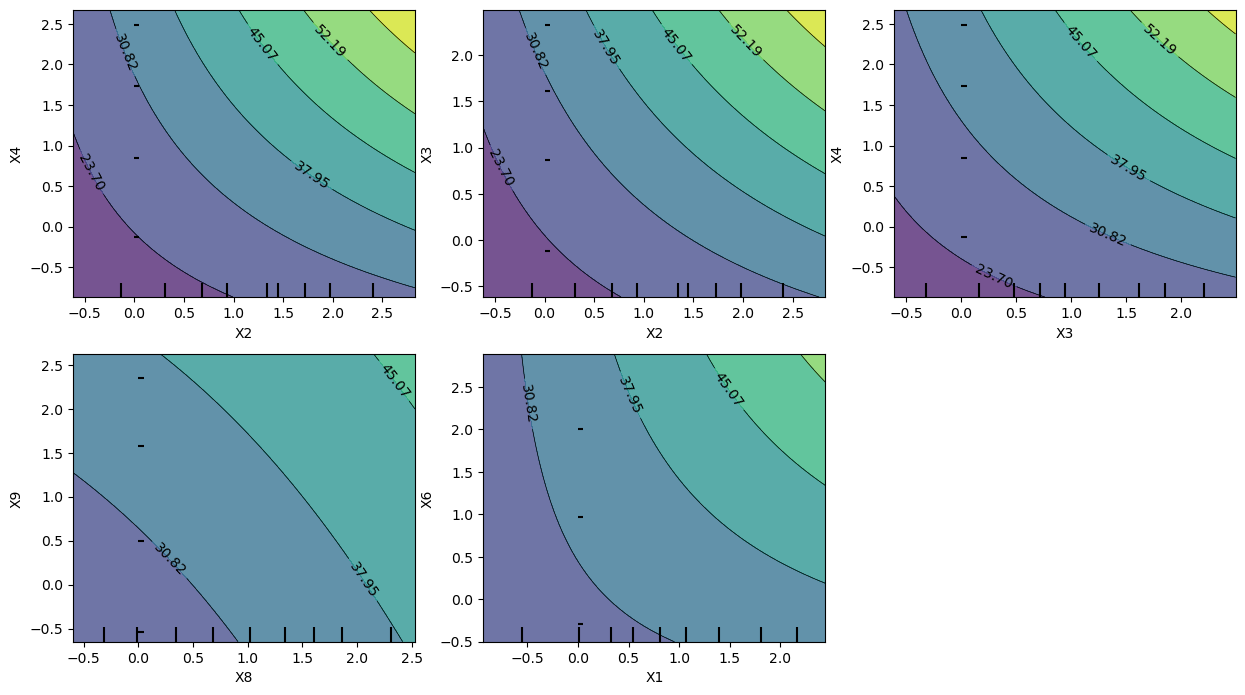

In [286]:
# draw two-dimensional PDP
fig6, ax6 = plt.subplots(figsize=(15, 8))
display4 = PartialDependenceDisplay.from_estimator(
    krls_optimized2, 
    X_test2, 
    [('X2', 'X4'), ('X2', 'X3'), ('X3', 'X4'), ('X8', 'X9'), ('X1', 'X6')], 
    ax=ax6
)
# plt.suptitle('Partial Dependence Plots for KRLS Model (with Interactions)')
plt.subplots_adjust(top=0.9)
plt.show()

# 3. Use complex data include nonlinear relationships to analyze

## a. Construct data

In [249]:
if __name__ == "__main__":
    np.random.seed(42)  # Make sure data can be repeatable

    # Define parameter
    beta_0_3 = 1
    betas_3 = np.random.uniform(1, 5, 5)  # random generation

    # Generate features
    X_3 = np.random.uniform(0, 1, (1000, 5))

    # Feature name
    feature_names3 = [f'X{i+1}' for i in range(5)]

    # Calculate Y
    Y_nonlinear = beta_0_3 + betas_3[0] * np.sin(X_3[:,0]) + betas_3[1] * np.log(X_3[:,1]) + betas_3[2] * X_3[:,2] + betas_3[3] * (X_3[:,3]**2) + betas_3[4] * X_3[:,4]
    # np.dot(X_3, betas_3) + beta_12 * np.sin(X_3[:,0]) * np.log(X_3[:,1]) + beta_34 * X_3[:,2] * (X_3[:,3]**2) + np.random.normal(0, 0.1, 1000)

    # Create DataFrame
    Synthetic_data3 = pd.DataFrame(X_3, columns=feature_names3)
    Synthetic_data3['Y'] = Y_nonlinear
    
    X_data_3 = Synthetic_data3.drop('Y', axis=1)
    Y_data_3 = Synthetic_data3['Y']
    
    # Split train and test dataset
    X_train3, X_test3, y_train3, y_test3 = train_test_split(X_data_3, Y_data_3, test_size=0.2, random_state=42)

In [250]:
# Perform linear regression
model_linear3 = LinearRegression()
model_linear3.fit(X_data_3, Y_data_3)

# Predict Y values
Y_pred_linear3 = model_linear3.predict(X_data_3)

# Print coefficients
print("Coefficients:", model_linear3.coef_)
print("Intercept:", model_linear3.intercept_)

# Evaluate the model
mse_linear3 = mean_squared_error(Y_data_3, Y_pred_linear3)
r2_linear3 = r2_score(Y_data_3, Y_pred_linear3)
print("Mean Squared Error:", mse_linear3)
print("R-squared:", r2_linear3)

Coefficients: [ 2.31446809 14.80137899  3.21016543  3.00190714  1.86367323]
Intercept: -11.50482399981609
Mean Squared Error: 7.835387871439307
R-squared: 0.7330149147894263


## b. find hyperparameter

In [251]:
"""
Optimize the hyperparameter of KRLS
"""

# Define grid
param_grid3 = {
    'sigma': np.logspace(-2, 2, 5),
    'alpha': np.logspace(-2, 2, 5)
}

# Use grid search
grid_search3 = GridSearchCV(KRLS(), param_grid3, cv=5, scoring='r2', verbose=1)
grid_search3.fit(X_train3, y_train3)

# Output optimized hyperparameters
print("Best parameters:", grid_search3.best_params_)
print("Best cross-validation score (r2):", grid_search3.best_score_)

# Use optimized hyperparameters to retrain the KRLS model
best_sigma3 = grid_search3.best_params_['sigma']
best_alpha3 = grid_search3.best_params_['alpha']

krls_optimized3 = KRLS(sigma=best_sigma3, alpha=best_alpha3)
krls_optimized3.fit(X_train3, y_train3)

# Use optimized KRLS model to predict
y_pred_optimized3 = krls_optimized3.predict(X_test3)
mse_optimized3 = mean_squared_error(y_test3, y_pred_optimized3)
print("Optimized Mean Squared Error:", mse_optimized3)

# Calculate out-of-sample R^2
r2_optimized3 = r2_score(y_test3, y_pred_optimized3)
print("Optimized Out-of-Sample R^2:", r2_optimized3)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'alpha': 0.01, 'sigma': 1.0}
Best cross-validation score (r2): 0.9118962404343991
Optimized Mean Squared Error: 5.9930325010381535
Optimized Out-of-Sample R^2: 0.8373405936519083


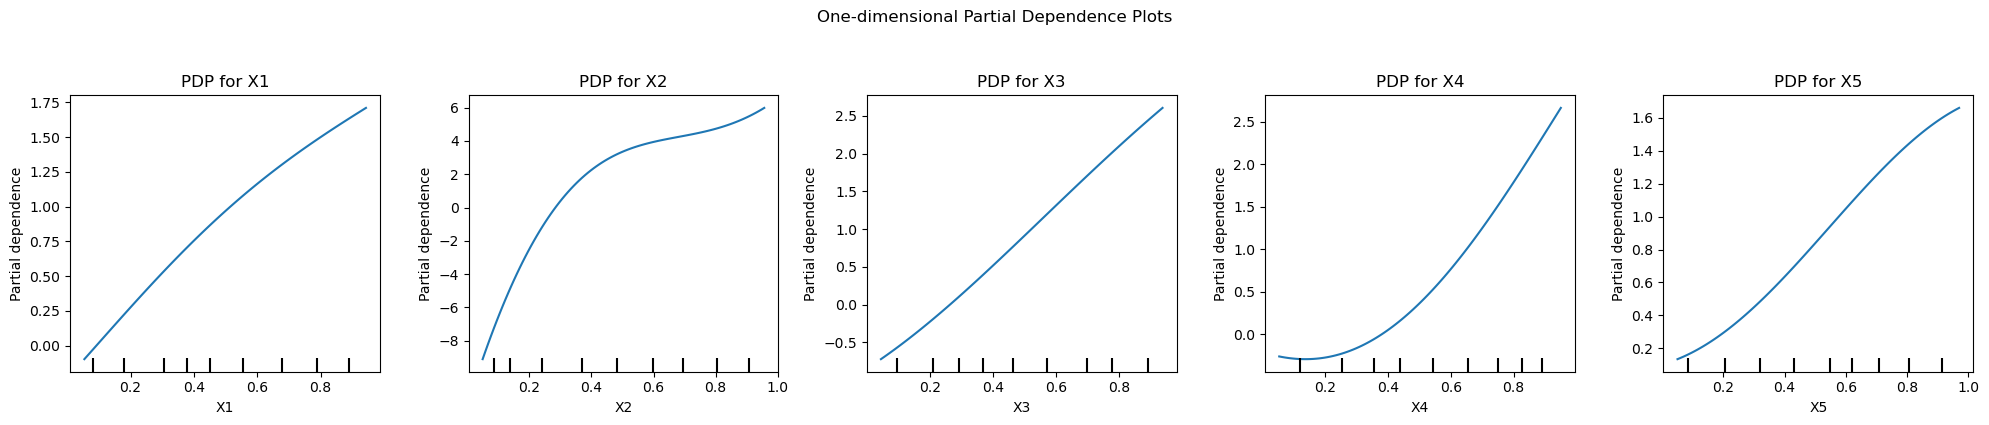

In [263]:
# Create figure
fig7, axes7 = plt.subplots(ncols=5, figsize=(20, 4))

# Draw PDP
features_to_plot3 = ['X1', 'X2', 'X3', 'X4', 'X5']
for i, feature in enumerate(features_to_plot3):
    display = PartialDependenceDisplay.from_estimator(
        krls_optimized3,
        X_test3,
        features=[feature],
        kind='average',
        ax=axes7[i]
    )
    axes7[i].set_title(f'PDP for {feature}')
    axes7[i].set_xlabel(feature)
    axes7[i].set_ylabel('Partial Dependence')

# Set title
fig7.suptitle('One-dimensional Partial Dependence Plots', y=1.05)
plt.tight_layout()
plt.show()

Comparison of average partial derivatives and coefficients of features:
    Average_Derivative  Coefficient  Difference
X1            2.019362     2.498160   -0.478799
X2           20.107361     4.802857   15.304504
X3            3.720445     3.927976   -0.207531
X4            3.387920     3.394634   -0.006714
X5            1.575347     1.624075   -0.048728


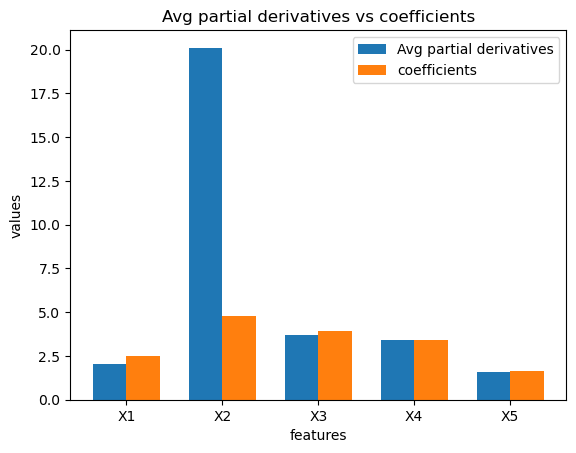

In [280]:
"""
Calculate partial dependence
"""

feature_names3 = X_train3.columns

# Initilize dictionary
derivatives_with_labels3 = {}
average_derivatives3 = {}

for feature_index, feature_name in enumerate(feature_names3):
    # Calculate partial dependence
    derivative3 = approximate_derivative(krls_optimized3, X_test3.to_numpy(), feature_index)
    
    # Calculate average partial dependence
    average_derivative3 = np.mean(derivative3)
    average_derivatives3[feature_name] = average_derivative3
    derivatives_with_labels3[feature_name] = derivative3
    
# Collect all average partial dependence
average_derivatives_str3 = ", ".join([f"{feature_name}: {average_derivative:.4f}" for feature_name, average_derivative in average_derivatives3.items()])

beta_coefficients3 = {
    'X1': betas_3[0],
    'X2': betas_3[1],
    'X3': betas_3[2],
    'X4': betas_3[3],
    'X5': betas_3[4],
}

# Trans to dataframe
df_derivatives3 = pd.DataFrame.from_dict(average_derivatives3, orient='index', columns=['Average_Derivative'])
df_derivatives3['Coefficient'] = [beta_coefficients3[feature_name] for feature_name in df_derivatives3.index]
df_derivatives3['Difference'] = df_derivatives3['Average_Derivative'] - df_derivatives3['Coefficient']

# print result
print("Comparison of average partial derivatives and coefficients of features:")
print(df_derivatives3)

# Draw figure
features3 = df_derivatives3.index
average_derivative_values3 = df_derivatives3['Average_Derivative']
beta_values3 = df_derivatives3['Coefficient']

x3 = np.arange(len(features3))
width = 0.35

fig8, ax8 = plt.subplots()
rects5 = ax8.bar(x3 - width/2, average_derivative_values3, width, label='Avg partial derivatives')
rects6 = ax8.bar(x3 + width/2, beta_values3, width, label='coefficients')

ax8.set_xlabel('features')
ax8.set_ylabel('values')
ax8.set_title('Avg partial derivatives vs coefficients')
ax8.set_xticks(x3)
ax8.set_xticklabels(features3)
ax8.legend()

plt.show()

特征的平均偏导数与系数的比较：
    Average_Derivative  Coefficient  Difference
X1            2.019362     2.314468   -0.295106
X2           20.107361    14.801379    5.305982
X3            3.720445     3.210165    0.510280
X4            3.387920     3.001907    0.386012
X5            1.575347     1.863673   -0.288326


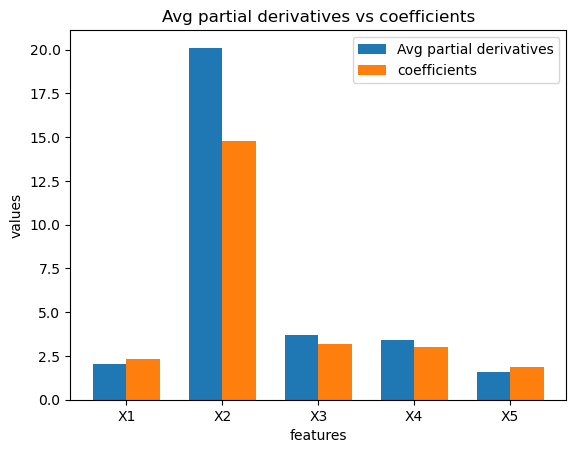

In [274]:
"""
Calculate partial derivatives
"""

feature_names33 = X_train3.columns

# Initialize dictionary
derivatives_with_labels33 = {}
average_derivatives33 = {}

for feature_index, feature_name in enumerate(feature_names33):
    # Calculate partial derivatives
    derivative = approximate_derivative(krls_optimized3, X_test3.to_numpy(), feature_index)
    
    # Calculate average partial dependence
    average_derivative = np.mean(derivative)
    average_derivatives33[feature_name] = average_derivative
    derivatives_with_labels33[feature_name] = derivative
    
# Collect all average partial derivatives
average_derivatives_str33 = ", ".join([f"{feature_name}: {average_derivative:.4f}" for feature_name, average_derivative in average_derivatives1.items()])

# Use coefficients of linear regression
linear_coefficients3 = model_linear3.coef_

# Trans to dataframe
df_derivatives33 = pd.DataFrame.from_dict(average_derivatives33, orient='index', columns=['Average_Derivative'])
df_derivatives33['Coefficient'] = linear_coefficients3
df_derivatives33['Difference'] = df_derivatives33['Average_Derivative'] - df_derivatives33['Coefficient']

# print results
print("Comparison of average partial derivatives and coefficients of features:")
print(df_derivatives33)

# Draw figure
features33 = df_derivatives33.index
average_derivative_values33 = df_derivatives33['Average_Derivative']
linear_coefficients_values33 = df_derivatives33['Coefficient']

x33 = np.arange(len(features33))
width = 0.35

fig88, ax88 = plt.subplots()
rects55 = ax88.bar(x33 - width/2, average_derivative_values33, width, label='Avg partial derivatives')
rects66 = ax88.bar(x33 + width/2, linear_coefficients_values33, width, label='coefficients')

ax88.set_xlabel('features')
ax88.set_ylabel('values')
ax88.set_title('Avg partial derivatives vs coefficients')
ax88.set_xticks(x33)
ax88.set_xticklabels(features33)
ax88.legend()

plt.show()

## c. Find interactions

In [275]:
X_train3_copy1 = X_train3.copy()
y_train3_copy1 = y_train3.copy()
interaction_scores3 = []

# Find all possible interaction terms
selected_columns3 = ['X1', 'X2', 'X3']
all_pairs3 = list(combinations(selected_columns3, 2))

for pair in all_pairs3:
    # Add interaction terms
    X_train_interacted3 = add_interaction_terms(X_train3_copy1, [pair])
    
    # Use cross-validation to evaluate
    score3 = np.mean(cross_val_score(krls_optimized3, X_train_interacted3, y_train3_copy1, cv=5, scoring='r2'))
    interaction_scores3.append((pair, score3))

# order by scores
sorted_interactions3 = sorted(interaction_scores3, key=lambda x: x[1], reverse=True)

# Find top N interaction terms
N = 5
best_interactions3 = sorted_interactions3[:N]

# print top N interaction terms
print(f"Top {N} interactions:")
for interaction, score in best_interactions3:
    print(f"Interaction: {interaction}, Mean Score: {score}")

Top 5 interactions:
Interaction: ('X2', 'X3'), Mean Score: 0.9169983954935811
Interaction: ('X1', 'X2'), Mean Score: 0.9149371931760276
Interaction: ('X1', 'X3'), Mean Score: 0.9097176732310821


In [255]:
# prepare data
X_train3_copy2 = X_train3.copy()
y_train3_copy2 = y_train3.copy()

threshold = 0.001
previous_best_mse3 = np.inf
N3 = 5
original_features3 = X_train3_copy2.columns.tolist()
selected_interactions3 = []

for iteration in range(N3):
    best_score3 = -np.inf
    best_interaction3 = None
    best_mse3 = np.inf
    best_r2_3 = -np.inf
    
    # Only consider pairwise interactions
    all_pairs33 = list(combinations(original_features3, 2))
    
    for pair in all_pairs33:
        # Create new dataset
        X_train_interacted = X_train3_copy2.copy()
        interaction_name3 = "_".join(pair) + "_interaction"
        X_train_interacted[interaction_name3] = X_train_interacted[pair[0]] * X_train_interacted[pair[1]]
        
        # Use cross-validation to evaluate
        scores3 = cross_validate(krls_optimized3, X_train_interacted, y_train3_copy2, cv=5, scoring=('neg_mean_squared_error', 'r2'))
        current_mse3 = -np.mean(scores3['test_neg_mean_squared_error'])
        current_r2_3 = np.mean(scores3['test_r2'])
        
        if current_mse3 < best_mse3:
            best_mse3 = current_mse3
            best_interaction3 = pair
            best_interaction_name3 = interaction_name3
            best_r2_3 = current_r2_3

    if previous_best_mse3 - best_mse3 < threshold:
        print("MSE improvement is below the threshold. Stopping iteration.")
        break
    else:
        previous_best_mse3 = best_mse3
        if best_interaction3:
            selected_interactions3.append(best_interaction3)
            print(f"Iteration {iteration+1}: Selected interaction: {best_interaction3}, Mean MSE: {best_mse3}, Mean R2: {best_r2_3}")
            # renew the dataset
            X_train3_copy2[best_interaction_name3] = X_train3_copy2[best_interaction3[0]] * X_train3_copy2[best_interaction3[1]]
        else:
            print("No further improvement.")
            break

Iteration 1: Selected interaction: ('X2', 'X3'), Mean MSE: 2.299584344109269, Mean R2: 0.9169983954935811
Iteration 2: Selected interaction: ('X1', 'X2'), Mean MSE: 2.1902001323815745, Mean R2: 0.9208564420676442
Iteration 3: Selected interaction: ('X2', 'X4'), Mean MSE: 2.081195883380264, Mean R2: 0.924852017423697
Iteration 4: Selected interaction: ('X2', 'X5'), Mean MSE: 1.9990776823477099, Mean R2: 0.9278863987637858
MSE improvement is below the threshold. Stopping iteration.


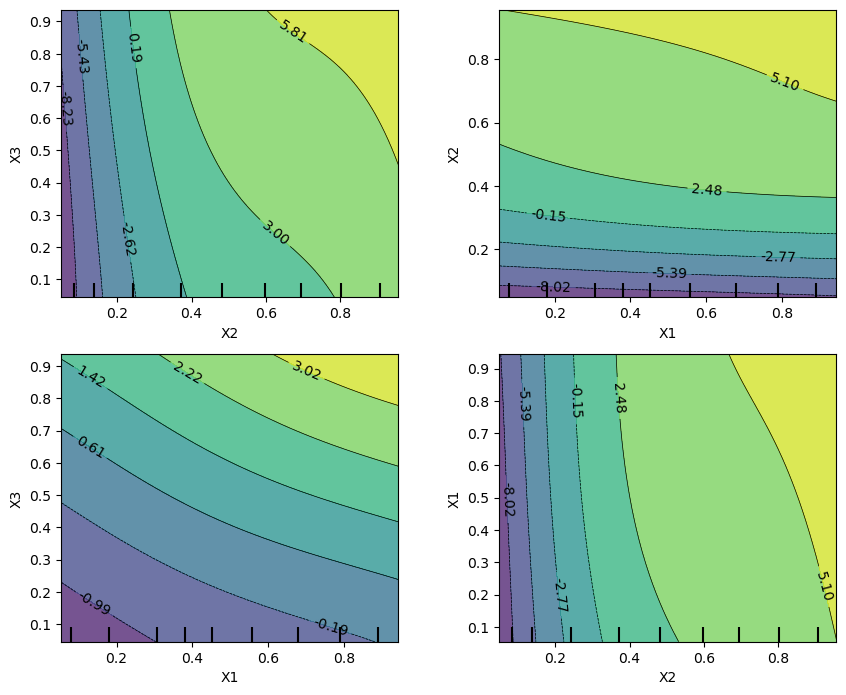

In [295]:
# Draw two-dimensional PDP
fig9, ax9 = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))  # Create a 2x2 grid for the plots
ax9 = ax9.flatten()  # Flatten the axes array for easy indexing

# Create partial dependence plots for each pair of features
PartialDependenceDisplay.from_estimator(
    krls_optimized3, 
    X_test3, 
    [('X2', 'X3')], 
    ax=ax9[0]
)
PartialDependenceDisplay.from_estimator(
    krls_optimized3, 
    X_test3, 
    [('X1', 'X2')], 
    ax=ax9[1]
)
PartialDependenceDisplay.from_estimator(
    krls_optimized3, 
    X_test3, 
    [('X1', 'X3')], 
    ax=ax9[2]
)

PartialDependenceDisplay.from_estimator(
    krls_optimized3, 
    X_test3, 
    [('X2', 'X1')], 
    ax=ax9[3]
)

# plt.suptitle('Partial Dependence Plots for KRLS Model (with Interactions)')
plt.subplots_adjust(top=0.9, hspace=0.2, wspace=0.3)  # Adjust hspace and wspace for spacing
plt.show()